# RBF-SVC on Amazon Fine Food Reviews dataset

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Classification of Amazon reviews with polarity based color-coding (that means predicting wheater review is positive or not)

# Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

In [1]:

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = sqlite3.connect('database.sqlite') #connecting to 'database.sqlite' and reading data from it 

filter_amz_data = pd.read_sql_query(""" 
SELECT *
FROM Reviews
WHERE Score != 3
""", con) # taking only those reviews having score greater than 3(4,5) and less than 3(1,2) not taking reviews of score 3


def partition_positive_negative(x): # Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filter_amz_data['Score']
positiveNegative = actualScore.map(partition_positive_negative) #map() will maps inputs of 'actualscore' using function partition
filter_amz_data['Score'] = positiveNegative

In [2]:
sample_amz_data = filter_amz_data.head(30000) #Sampled amazon fine foood reviews filtered data to 15k datapoints for time effiecieny

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication


In [3]:
#Sorting data according to ProductId in ascending order; sorting is necessary because if duplicates entries are there than we want to have only one of it and that we get from first entry of duplicates entries after sorting

sorted_data = sample_amz_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

**sorting is necessary because if duplicates entries are there than we want to have only one of it and that we get from first entry of duplicates entries after sorting**

In [4]:
#Deduplication of entries

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(sorted_data.shape) 
print(final.shape)

(30000, 10)
(28072, 10)


**As we can see that in sorted_data there are 15k points but now after removing duplicates entries we git some 14k points**

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
# It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator 
#which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(28072, 10)


1    23606
0     4466
Name: Score, dtype: int64

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
import re
import nltk
import string
from nltk.corpus import stopwords # nltk- natural language processing toolkit
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
s=''
for sent in final['Text'].values: #taking each reviews
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split(): # taking each words of each reviews
        for cleaned_words in cleanpunc(w).split(): #cleanpunc(w) will remove any punctuations/special symbols from each word
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):   #checking word should be only have alphabets not aplha-numeric/numeric and all words should have length >2 
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #returing each word to be in lower case
                    filtered_sentence.append(s) # appending each filtered word of reviews to the list
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

<h2>Sorting dataset based on 'Time' feature</h2>

In [11]:
sorted_Time_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


<h1>Techniques for Vectorization/Featurization Text data :--</h1>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# (1) Bag of Words (BoW)

In [48]:
#Bow

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 
final_counts_Bow= count_vect.fit_transform(sorted_Time_data['CleanedText'].values) # computing Bow
print(type(final_counts_Bow))
print(final_counts_Bow.shape)

#Spliting dataset to training(with first 70% points) and test(remaining 30% points) dataset

n=len(sorted_Time_data)

tr=final_counts_Bow[0:(int(n*0.7))+1,:] #taking first 70% of points from sorted dataset based on 'Time' feature
labels_Bow_tr=sorted_Time_data['Score'].head(int(n*0.7)+1)


ts=final_counts_Bow[(int(n*0.7))+1:,:]   #taking remaining 30% of points from sorted dataset based on 'Time' feature
labels_Bow_ts=sorted_Time_data['Score'].tail(int(n*0.3))

print(tr.shape)
print(labels_Bow_tr.shape)
print(ts.shape)
print(labels_Bow_ts.shape)


# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_train = MaxAbsScaler().fit_transform(tr)
standardized_data_test = MaxAbsScaler().fit_transform(ts)
print(standardized_data_train.shape)
print(standardized_data_test.shape)



<class 'scipy.sparse.csr.csr_matrix'>
(28072, 19423)
(19651, 19423)
(19651,)
(8421, 19423)
(8421,)
(19651, 19423)
(8421, 19423)


<h2>1.1 Grid Search on SVC Classifier for computing optimal hyperparameter</h2>

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid=[{'C': [1, 10, 100, 1000],
             'gamma': [0.001, 0.0001], 
             'kernel': ['rbf']}]

clf=SVC()
gscv = GridSearchCV(clf, param_grid, n_jobs=-1)
gscv.fit(standardized_data_train, labels_Bow_tr)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
print(gscv.best_params_ )

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [15]:
print(gscv.best_estimator_ )

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


<h2> 1.2 Computing optimal 'C' for RBF-SVC using 10-fold cross-validation and plotting misclassification error</h2>


The optimal C is 100.


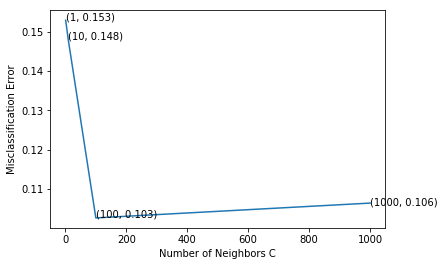

the misclassification error for each C value is :  [0.153 0.148 0.103 0.106]


In [24]:
from sklearn.cross_validation import cross_val_score

# creating odd list of C 
myList = [int(x) for x in np.logspace(0,3,4)]


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for c in myList:
    svc_clf = SVC(C=c, kernel= 'rbf',gamma= 0.001)
    scores = cross_val_score(svc_clf, standardized_data_train, labels_Bow_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - y for y in cv_scores]

# determining best k
optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal C is %d.' % optimal_c)

# plot misclassification error vs k 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors C')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

<h2> 1.3 computing Train error </h2>

In [18]:
from sklearn.svm import SVC

rbfsvc_clf =  SVC(C=100, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train, labels_Bow_tr)
y_pred_tr = rbfsvc_clf.predict(standardized_data_train)
acc_tr = accuracy_score(labels_Bow_tr,y_pred_tr)
train_error = 1-acc_tr
print('\nTrain accuracy is : {}'.format(acc_tr))
print('\nTrain error is : {}'.format(train_error))


Train accuracy is : 0.9412243651722558

Train error is : 0.05877563482774417


<h2> 1.4 Computing Test error </h2>

In [19]:
from sklearn.svm import SVC

rbfsvc_clf =  SVC(C=100, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train, labels_Bow_tr)
y_pred_ts = rbfsvc_clf.predict(standardized_data_test)
acc_ts = accuracy_score(labels_Bow_ts,y_pred_ts)
test_error = 1-acc_ts
print('\nTest accuracy is : {}'.format(acc_ts))
print('\nTest error is : {}'.format(test_error))


Test accuracy is : 0.9040494003087519

Test error is : 0.09595059969124808


<h2> 1.5 Plotting confusion matrix,/h2>

In [44]:
svc_clf = SVC(C=100, kernel= 'rbf',gamma= 0.001)
y_pred = svc_clf.fit(standardized_data_train, labels_Bow_tr).predict(standardized_data_test)

-------------------- Confusion matrix --------------------


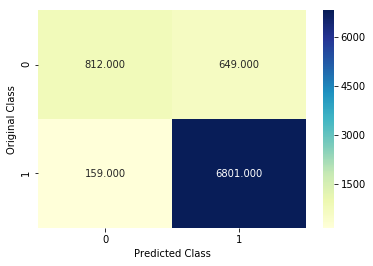

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

C = confusion_matrix(labels_Bow_ts, y_pred)
labels = [0,1] #label 0 means they are negative reviews
#label 1 means they are positive reviews

print("-"*20, "Confusion matrix", "-"*20)
#plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()


<b>Observation(s):--</b>
1. Points that are predicted by SVC model as class 0 from them 812 points are actually of class 0 and 159 points are of class 1.

2. Points that are predicted by SVC model as class 1 from them 6801 points are actually of class 1 and 649 points are of class 0.

# (2) TF-IDF 

In [20]:
#tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer()
final_counts_tfidf= tf_idf_vect.fit_transform(sorted_Time_data['CleanedText'].values) 
print(type(final_counts_tfidf))
print(final_counts_tfidf.shape)

#Spliting dataset to training(with first 70% points) and test(remaining 30% points) dataset

n=len(sorted_Time_data)
tr_tfidf=final_counts_tfidf[0:(int(n*0.7))+1,:]  #taking first 70% of points from sorted dataset based on 'Time' feature
labels_tfidf_tr=sorted_Time_data['Score'].head(int(n*0.7)+1)

ts_tfidf=final_counts_tfidf[(int(n*0.7))+1:,:]   #taking remaining 30% of points from sorted dataset based on 'Time' feature
labels_tfidf_ts=sorted_Time_data['Score'].tail(int(n*0.3))

print(tr_tfidf.shape)
print(labels_tfidf_tr.shape)
print(ts_tfidf.shape)
print(labels_tfidf_ts.shape)


# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_train_tfidf = MaxAbsScaler().fit_transform(tr_tfidf)
standardized_data_test_tfidf = MaxAbsScaler().fit_transform(ts_tfidf)
print(standardized_data_train_tfidf.shape)
print(standardized_data_test_tfidf.shape)




<class 'scipy.sparse.csr.csr_matrix'>
(28072, 19423)
(19651, 19423)
(19651,)
(8421, 19423)
(8421,)
(19651, 19423)
(8421, 19423)


<h2>2.1 Grid Search on SVC Classifier for computing optimal hyperparameter</h2>

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid=[{'C': [1, 10, 100, 1000],
             'gamma': [0.001, 0.0001], 
             'kernel': ['rbf']}]

clf=SVC()
gscv = GridSearchCV(clf, param_grid, n_jobs=-1)
gscv.fit(standardized_data_train_tfidf, labels_tfidf_tr)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
print(gscv.best_estimator_ )

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [40]:
print(gscv.best_params_ )

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


<h2> 2.2 Computing optimal 'C' for RBF-SVC using 10-fold cross-validation and plotting misclassification error</h2>


The optimal C is 100.


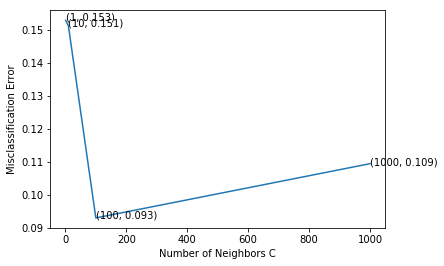

the misclassification error for each C value is :  [0.153 0.151 0.093 0.109]


In [26]:
from sklearn.cross_validation import cross_val_score

# creating odd list of C 
myList = [int(x) for x in np.logspace(0,3,4)]


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for c in myList:
    svc_clf = SVC(C=c, kernel= 'rbf',gamma= 0.001)
    scores = cross_val_score(svc_clf,standardized_data_train_tfidf, labels_tfidf_tr, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - y for y in cv_scores]

# determining best k
optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal C is %d.' % optimal_c)

# plot misclassification error vs k 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors C')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

<h2> 2.2 Computing Train error </h2>

In [21]:
rbfsvc_clf = SVC(C=100, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train_tfidf, labels_tfidf_tr)
y_pred_tr = rbfsvc_clf.predict(standardized_data_train_tfidf)
acc_tr = accuracy_score(labels_tfidf_tr,y_pred_tr)
train_error = 1-acc_tr
print('\n Train accuracy is : {}'.format(acc_tr))
print('\n Train error is : {}'.format(train_error))


 Train accuracy is : 0.9536919240751107

 Train error is : 0.04630807592488928


<h2> 2.3 Computing Test error </h2>

In [22]:
rbfsvc_clf = SVC(C=100, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train_tfidf, labels_tfidf_tr)
y_pred_ts = rbfsvc_clf.predict(standardized_data_test_tfidf)
acc_ts = accuracy_score(labels_tfidf_ts,y_pred_ts)
test_error = 1-acc_ts
print('\n Test accuracy is : {}'.format(acc_ts))
print('\n Test error is : {}'.format(test_error))


 Test accuracy is : 0.9104619403871275

 Test error is : 0.08953805961287253


<h2> 2.4 Plotting confusion matrix </h2>

In [31]:
svc_clf = SVC(C=100, kernel= 'rbf',gamma= 0.001)
y_pred = svc_clf.fit(standardized_data_train_tfidf, labels_tfidf_tr).predict(standardized_data_test_tfidf)

-------------------- Confusion matrix --------------------


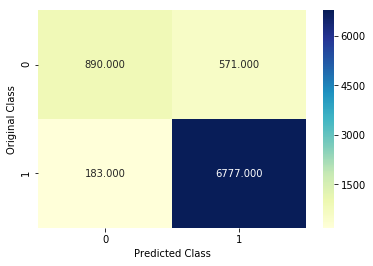

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

C = confusion_matrix(labels_tfidf_ts, y_pred)
labels = [0,1] #label 0 means they are negative reviews
#label 1 means they are positive reviews

print("-"*20, "Confusion matrix", "-"*20)
#plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()


<b>Observation(s):--</b>
1. Points that are predicted by SVC model as class 0 from them 890 points are actually of class 0 and 183 points are of class 1.

2. Points that are predicted by SVC model as class 1 from them 6777 points are actually of class 1 and 571 points are of class 0.

# (3) Average word2vec

<h2>3.1 Train and Test data split into 70:30 ratio</h2>

In [23]:
#Spliting dataset to training(with first 70% points) and test(remaining 30% points) dataset

n=len(sorted_Time_data)

tr=sorted_Time_data.head((int(n*0.7))+1)#taking first 70% of points from sorted dataset based on 'Time' feature
labels_tr=sorted_Time_data['Score'].head(int(n*0.7)+1)


ts=sorted_Time_data.tail((int(n*0.3)))   #taking remaining 30% of points from sorted dataset based on 'Time' feature
labels_ts=sorted_Time_data['Score'].tail(int(n*0.3))

print(tr.shape)
print(labels_tr.shape)
print(ts.shape)
print(labels_ts.shape)

(19651, 11)
(19651,)
(8421, 11)
(8421,)


<h2>3.2 Computing word2vector for Train data</h2>

In [25]:
# Train our own Word2Vec model using our own text corpus of train dataset
import gensim
i=0
list_of_sent_tr=[]
for sent in tr['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_tr.append(filtered_sentence)
    

In [26]:
w2v_model_tr=gensim.models.Word2Vec(list_of_sent_tr,min_count=1,size=50, workers=4)    
# min_count here says that if a word doesn't occur atleast 5 times than not construct its word2vector
# size means dimension of each vector of word  , here is 50 dimension

In [27]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_tr.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)


In [28]:

# Data-preprocessing: Standardizing the train data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_train_avgw2v = MaxAbsScaler().fit_transform(sent_vectors_tr)
print(standardized_data_train_avgw2v.shape)



(19651, 50)


<h2> 3.3 Computing word2vector for test data</h2>

In [29]:
# Train our own Word2Vec model using our own text corpus of test data
import gensim
i=0
list_of_sent_ts=[]
for sent in ts['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_ts.append(filtered_sentence)
    

In [30]:
w2v_model_ts=gensim.models.Word2Vec(list_of_sent_ts,min_count=1,size=50, workers=4)    
# min_count here says that if a word doesn't occur atleast 5 times than not construct its word2vector
# size means dimension of each vector of word  , here is 50 dimension

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_ts = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_ts: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_ts.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_ts.append(sent_vec)


In [32]:

# Data-preprocessing: Standardizing the test data

from sklearn.preprocessing import MaxAbsScaler
standardized_data_test_avgw2v = MaxAbsScaler().fit_transform(sent_vectors_ts)
print(standardized_data_test_avgw2v.shape)



(8421, 50)


<h2>3.4 Grid search on SVC Classifier for computing optimal hyperparameter</h2>

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid=[{'C': [1, 10, 100, 1000],
             'gamma': [0.001, 0.0001], 
             'kernel': ['rbf']}]

clf_w2v=SVC()
gscv_w2v = GridSearchCV(clf_w2v, param_grid, n_jobs=-1)
gscv_w2v.fit(standardized_data_train_avgw2v, labels_tr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
print(gscv_w2v.best_estimator_)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [19]:
print(gscv_w2v.best_params_ )

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


<h2> 3.5 Computing optimal 'C' for RBF-SVC using 10-fold cross-validation and plotting misclassification error</h2>


The optimal C is 1000.


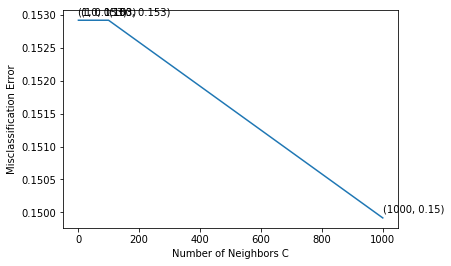

the misclassification error for each C value is :  [0.153 0.153 0.153 0.15 ]


In [33]:
from sklearn.cross_validation import cross_val_score

# creating odd list of C 
myList = [int(x) for x in np.logspace(0,3,4)]


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for c in myList:
    svc_clf = SVC(C=c, kernel= 'rbf',gamma= 0.001)
    scores = cross_val_score(svc_clf,standardized_data_train_avgw2v, labels_tr, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - y for y in cv_scores]

# determining best k
optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal C is %d.' % optimal_c)

# plot misclassification error vs k 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors C')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

<h2> 3.6 Computing Train error</h2>

In [46]:
rbfsvc_clf = SVC(C=1000, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train_avgw2v, labels_tr)
y_pred_tr = rbfsvc_clf.predict(standardized_data_train_avgw2v)
acc_tr = accuracy_score(labels_tr,y_pred_tr)
train_error = 1-acc_tr
print('\n Train accuracy is : {}'.format(acc_tr))
print('\n Train error is : {}'.format(train_error))


 Train accuracy is : 0.8563940766373213

 Train error is : 0.14360592336267874


<h2> 3.7 Computing Test error </h2>

In [47]:
rbfsvc_clf = SVC(C=100, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train_avgw2v, labels_tr)
y_pred_ts = rbfsvc_clf.predict(standardized_data_test_avgw2v)
acc_ts = accuracy_score(labels_ts,y_pred_ts)
test_error = 1-acc_ts
print('\n Test accuracy is : {}'.format(acc_ts))
print('\n Test error is : {}'.format(test_error))


 Test accuracy is : 0.8265051656572854

 Test error is : 0.17349483434271462


<h2> 3.8 Plotting confusion matrix </h2>

In [33]:
svc_clf = SVC(C=1000, kernel= 'rbf',gamma= 0.001)
y_pred = svc_clf.fit(standardized_data_train_avgw2v, labels_tr).predict(standardized_data_test_avgw2v)

-------------------- Confusion matrix --------------------


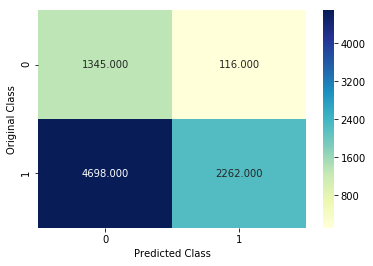

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

C = confusion_matrix(labels_ts, y_pred)
labels = [0,1] #label 0 means they are negative reviews
#label 1 means they are positive reviews

print("-"*20, "Confusion matrix", "-"*20)
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()


<b>Observation(s):--</b>
1. Points that are predicted by SVC model as class 0 from them 1345 points are actually of class 0 and 4698 points are of class 1.

2. Points that are predicted by SVC model as class 1 from them 2262 points are actually of class 1 and 116 points are of class 0.


# (4) TF-IDF Weighted Word2Vec

<h2>4.1 Computing tfidf weighted word2vec for train data</h2>

In [35]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect_tr = TfidfVectorizer()
final_counts_tfidfw2v_tr= tfidfw2v_vect_tr.fit_transform(tr['Text'].values) 
print(type(final_counts_tfidfw2v_tr))
print(final_counts_tfidfw2v_tr.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(19651, 26832)


In [36]:
labels_tfidfw2v_tr=sorted_Time_data['Score'].head(int(n*0.7)+1) #class_labels for train data
labels_tfidfw2v_ts=sorted_Time_data['Score'].tail(int(n*0.3)) #class_labels for test data
print(labels_tfidfw2v_tr.shape)
print(labels_tfidfw2v_ts.shape)

(19651,)
(8421,)


In [37]:
t_tr=tfidfw2v_vect_tr.get_feature_names()
t1_tr=list()
ro=0
for sen in list_of_sent_tr:
    revec=np.zeros(50)
    wrsu=0
    for wro in sen:
        try:
            wve=w2v_model_tr.wv[wro]
            tfv=final_counts_tfidfw2v_tr[ro,t_tr.index(wro)]
            revec += (wve*tfv)
            wrsu += tfv
        except:
            pass
    revec /= wrsu
    t1_tr.append(revec)
    ro += 1

In [39]:


# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler

standardized_data_train_tfidfw2v = MaxAbsScaler().fit_transform(t1_tr)

print(standardized_data_train_tfidfw2v.shape)



(19651, 50)


<h2>4.2 Computing tfidf weighted word2vec for Test data</h2>

In [40]:
#tf-idf weighted w2v

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfw2v_vect_ts = TfidfVectorizer()
final_counts_tfidfw2v_ts= tfidfw2v_vect_ts.fit_transform(ts['Text'].values) 
print(type(final_counts_tfidfw2v_ts))
print(final_counts_tfidfw2v_ts.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(8421, 17504)


In [41]:
t_ts=tfidfw2v_vect_ts.get_feature_names()
t1_ts=list()
ro=0
for sen in list_of_sent_ts:
    revec=np.zeros(50)
    wrsu=0
    for wro in sen:
        try:
            wve=w2v_model_ts.wv[wro]
            tfv=final_counts_tfidfw2v_ts[ro,t_ts.index(wro)]
            revec += (wve*tfv)
            wrsu += tfv
        except:
            pass
    revec /= wrsu
    t1_ts.append(revec)
    ro += 1

In [42]:


# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import MaxAbsScaler

standardized_data_test_tfidfw2v = MaxAbsScaler().fit_transform(t1_ts)

print(standardized_data_test_tfidfw2v.shape)



(8421, 50)


<h2>4.3 Grid search on SVC Classifier for computing optimal hyperparameter</h2>

In [66]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid=[{'C': [1, 10, 100, 1000],
             'gamma': [0.001, 0.0001], 
             'kernel': ['rbf']}]

clf_tfidfw2v=SVC()
gscv_tfidfw2v = GridSearchCV(clf_tfidfw2v, param_grid, n_jobs=-1)
gscv_tfidfw2v.fit(standardized_data_train_tfidfw2v, labels_tfidfw2v_tr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [67]:
print(gscv_tfidfw2v.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [68]:
print(gscv_tfidfw2v.best_params_ )

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


<h2> 4.4 Computing optimal 'C' for RBF-SVC using 10-fold cross-validation and plotting misclassification error</h2>


The optimal C is 1.


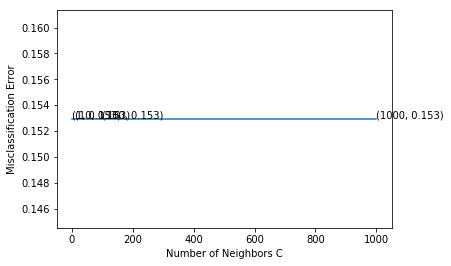

the misclassification error for each C value is :  [0.153 0.153 0.153 0.153]


In [41]:
from sklearn.cross_validation import cross_val_score

# creating odd list of C 
myList = [int(x) for x in np.logspace(0,3,4)]


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for c in myList:
    svc_clf = SVC(C=c, kernel= 'rbf',gamma= 0.001)
    scores = cross_val_score(svc_clf,standardized_data_train_tfidfw2v, labels_tfidfw2v_tr, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - y for y in cv_scores]

# determining best k
optimal_c = myList[MSE.index(min(MSE))]
print('\nThe optimal C is %d.' % optimal_c)

# plot misclassification error vs k 
plt.plot(myList, MSE)

for xy in zip(myList, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors C')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each C value is : ", np.round(MSE,3))

<h2> 4.4 Computing Train error</h2>

In [43]:
rbfsvc_clf = SVC(C=1, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train_tfidfw2v, labels_tfidfw2v_tr)
y_pred_tr = rbfsvc_clf.predict(standardized_data_train_tfidfw2v)
acc_tr = accuracy_score(labels_tfidfw2v_tr,y_pred_tr)
train_error = 1-acc_tr
print('\n Train accuracy is : {}'.format(acc_tr))
print('\n Train error is : {}'.format(train_error))


 Train accuracy is : 0.8470815734568216

 Train error is : 0.15291842654317844


<h2> 4.5 Computing Test error</h2>

In [49]:
rbfsvc_clf = SVC(C=1, kernel= 'rbf',gamma= 0.001)
rbfsvc_clf_model = rbfsvc_clf.fit(standardized_data_train_tfidfw2v, labels_tfidfw2v_tr)
y_pred_ts = rbfsvc_clf.predict(standardized_data_test_tfidfw2v)
acc_ts = accuracy_score(labels_tfidfw2v_ts,y_pred_ts)
test_error = 1-acc_ts
print('\n Test accuracy is : {}'.format(acc_ts))
print('\n Test error is : {}'.format(test_error))


 Test accuracy is : 0.8265051656572854

 Test error is : 0.17349483434271462


<h2> 4.6 Plotting confusion matrix</h2>

In [46]:
svc_clf = SVC(C=1, kernel= 'rbf',gamma= 0.001)
y_pred = svc_clf.fit(standardized_data_train_tfidfw2v, labels_tfidfw2v_tr).predict(standardized_data_test_tfidfw2v)

-------------------- Confusion matrix --------------------


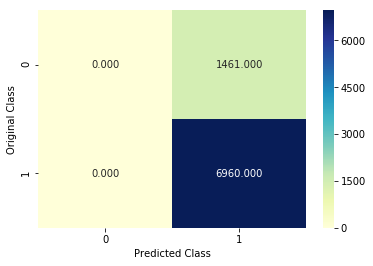

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

C = confusion_matrix(labels_tfidfw2v_ts, y_pred)
labels = [0,1] #label 0 means they are negative reviews
#label 1 means they are positive reviews

print("-"*20, "Confusion matrix", "-"*20)
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()


<b>Observation(s):--</b>
1. Points that are predicted by SVC model as class 0 from them no points are actually of class 0 and no points are of class 1. That means tfidfw2v based featurization SVC model not predict any points of class 0.

2. Points that are predicted by SVC model as class 1 from them 6960 points are actually of class 1 and 1461 points are of class 0.


<html>
<head>
<style>
table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
}
th, td {
    padding: 25px;
    text-align: left;
}

</style>
</head>
<body>

<h2>Summary</h2>
<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Best Hyperparameter</th> 
    <th>Train error</th>
    <th>Test error</th>
  </tr>
  <tr>
    <td>RBF-SVC + Bow</td>
      <td>'C': 100, 'gamma': 0.001, 'kernel': 'rbf'</td>
    <td>0.05877563482774417</td>
    <td>0.09595059969124808</td>
  </tr>
  <tr>
    <td>RBF-SVC + tfidf</td>
    <td>'C': 100, 'gamma': 0.001, 'kernel': 'rbf'</td>
    <td>0.04630807592488928</td>
    <td>0.08953805961287253</td>
  </tr>
 <tr>
    <td>RBF-SVC + avgw2v</td>
    <td>'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'</td>
    <td>0.14360592336267874</td>
    <td>0.17349483434271462</td>
  </tr>
 <tr>
    <td>RBF-SVC + tfidfw2v</td>
    <td>'C': 1, 'gamma': 0.001, 'kernel': 'rbf'</td>
    <td>0.15291842654317844</td>
    <td>0.17349483434271462</td>
  </tr>
</table>

</body>
</html>
